In [3]:
from envs.purchasing import PurchaseEnv

env = PurchaseEnv()

env.render()

Task prize: 8
Bidders' bids: [0, 12, 9, 11, 3, 10, 0, 8, 12, 1]
Bidders' distances: [1, 3, 1, 1, 1, 1, 1, 3, 3, 1]
Distance: 2


In [10]:
import joblib
import os
from stable_baselines3 import PPO

log_dir = "./runs/baselines"
model_path = os.path.join(log_dir, "best_model.zip")

# Load the model
model = PPO.load(model_path, env=env)

# Example usage of the model to make predictions
# Assuming you have some input data in a variable called `input_data`
# predictions = model.predict(input_data)
obs, _ = env.reset()

# write the env step 
action, _states = model.predict(obs)
obs, reward, done, truncated, info = env.step(action)
env.render()

# print the action and the reward
print("Action:", action)
print("Reward:", reward)

Task prize: 9
Bidders' bids: [9, 11, 2, 10, 11, 2, 3, 8, 12, 5]
Bidders' distances: [2, 1, 2, 2, 2, 3, 3, 1, 2, 1]
Distance: 2
Action: 7
Reward: 0


## things that would be cool to demonstrate

* performs better against adversarial bidding
* pseudo-guarantees optimality
* model inference time is quicker than calculating directly for large inputs

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.logger import configure
from envs.multiagent_purchasing import MultiAgent_PurchaseEnv
import os

# Create the environment
env = MultiAgent_PurchaseEnv(num_bidders=2)

# Configure TensorBoard logging
log_dir = "./runs/baselines/multiagent"
new_logger = configure(log_dir, ["stdout", "tensorboard"])

# Define a learning rate schedule
def linear_schedule(initial_value):
    def func(progress_remaining):
        return progress_remaining * initial_value
    return func

# Instantiate the agent with adaptive learning rate
model = PPO("MultiInputPolicy", env, verbose=0, n_steps=2048, batch_size=64, n_epochs=10, learning_rate=linear_schedule(3e-4), tensorboard_log=log_dir)
model.set_logger(new_logger)

# Create callbacks for saving models and evaluation
checkpoint_callback = CheckpointCallback(save_freq=int(1e4), save_path=f"{log_dir}/checkpoints", name_prefix='ppo_model')
eval_callback = EvalCallback(env, best_model_save_path=f"{log_dir}/best_model", log_path=log_dir, eval_freq=5000, deterministic=True, render=False)
callback = CallbackList([checkpoint_callback, eval_callback])

# Train the agent
model.learn(total_timesteps=int(1e5), callback=callback)

model_path = os.path.join(log_dir, "best_model.zip")

# Save the model
model.save(model_path)

# Test the trained agent
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward

print("Total reward after training with PPO:", total_reward)
env.render()

Logging to ./runs/baselines/multiagent
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.26     |
| time/              |          |
|    fps             | 2321     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.26        |
| time/                   |             |
|    fps                  | 1931        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.032792028 |
|    clip_fraction        | 0.618       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.68       |
|    explained_variance   | -0.04

/Users/devg/robopt/.venv/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.41     |
| time/              |          |
|    fps             | 1871     |
|    iterations      | 3        |
|    time_elapsed    | 3        |
|    total_timesteps | 6144     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.39        |
| time/                   |             |
|    fps                  | 1837        |
|    iterations           | 4           |
|    time_elapsed         | 4           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.032754444 |
|    clip_fraction        | 0.581       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 0.0263      |
|    lea

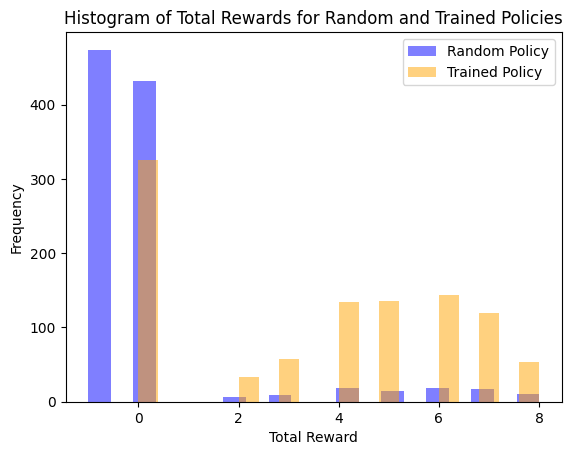

In [4]:
import matplotlib.pyplot as plt
from envs.multiagent_purchasing import MultiAgent_PurchaseEnv

# Update the environment with 20 bidders
env = MultiAgent_PurchaseEnv(num_bidders=2)

# Run random policy
random_rewards = []
for _ in range(1000):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    random_rewards.append(total_reward)

# Run trained policy
ppo_rewards = []
for _ in range(1000):
    obs, _= env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
    ppo_rewards.append(total_reward)

# Plot the results
plt.hist(random_rewards, bins=20, alpha=0.5, label='Random Policy', color='blue', density=False)
plt.hist(ppo_rewards, bins=20, alpha=0.5, label='Trained Policy', color='orange', density=False)
plt.legend(loc='upper right')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Total Rewards for Random and Trained Policies')
plt.show()

In [21]:
# Define a function to run the model and print the chosen action for different numbers of bidders
env = MultiAgent_PurchaseEnv(num_bidders=4)
obs, _ = env.reset()
action, _states = model.predict(obs)

obs, reward, done, truncated, info = env.step(action)

env.render()

print(f'\nWith prize {obs["prize"]} and distance {obs["distance"]}, chose action {action}')

print(f"Got reward: {reward}")

Task prize: 8
Bidders' bids: [5, 6, 5, 7]
Bidders' distances: [3, 2, 3, 1]
Distance: 2

With prize 8 and distance 2, chose action 7
Got reward: 6
